In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class EncoderNN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512):
        super(EncoderNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, latent_dim)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))

        return mu, sigma

In [3]:
class EncoderGaussian(nn.Module):
    def __init__(self, encoder):
        super(EncoderGaussian, self).__init__()
        self.encoder = encoder
    
    def sample(mu, std):
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return z
    
    def log_prob(mu, std, z):
        return torch.distributions.Normal(mu, std).log_prob(z)
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(log_var / 2)
        z = EncoderGaussian.sample(mu, std)
        return z, mu, std
    

In [4]:
class DecoderNN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=512):
        super(DecoderNN, self).__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z):
        out = F.relu(self.linear1(z))
        out = torch.sigmoid(self.linear2(out))
        return out

In [5]:
class DecoderGaussian(nn.Module):
    def __init__(self, decoder):
        super(DecoderGaussian, self).__init__()
        self.decoder = decoder
        self.log_variance = nn.Parameter(torch.Tensor([0.0]))
    
    def log_prob_xz(self, mean, log_variance, x):
        x = torch.flatten(x, start_dim=1)
        variance = torch.exp(log_variance)
        dist = torch.distributions.Normal(mean, variance)
        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1))
    
    def forward(self, z, x):
        out = self.decoder(z)
        recon_loss = self.log_prob_xz(out, self.log_variance, x)
        return out, recon_loss

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, beta):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = EncoderGaussian(encoder)
        self.decoder = DecoderGaussian(decoder)
        self.beta = beta

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        Dkl = (log_qzx - log_pz).sum(-1)
        return Dkl

    def sample(self, mean, log_variance):
        variance = torch.exp(log_variance)
        dist = torch.distributions.Normal(mean, variance)
        x_hat = dist.sample()
        return x_hat
    
    def forward(self, x):
        z, mu, std = self.encoder(x)
        decoder_out, recon_loss = self.decoder(z, x)
        Dkl = self.kl_divergence(z, mu, std)
        elbo = (Dkl * self.beta - recon_loss).mean()
        elbo2 = (Dkl - recon_loss).mean()
        x_hat = self.sample(decoder_out, self.decoder.log_variance)
        return decoder_out, self.decoder.log_variance, elbo, Dkl.mean(), recon_loss.mean(), x_hat, z, elbo2

In [7]:
def train(VAE, dataloader, optimizer, device='cpu'):
    device = torch.device(device)
    VAE = VAE.to(device)
    train_elbo = 0
    train_Dkl = 0
    train_recon_loss = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        _, _, elbo, Dkl, recon_loss, _, _, elbo2 = VAE(X)
        # Backpropagation
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        train_elbo += elbo2
        train_Dkl += Dkl
        train_recon_loss += recon_loss
        
        if batch % 100 == 0:
            elbo, current = elbo.item(), batch * len(X)
            #print(f"elbo: {elbo:>7f}  [{current:>5d}/{size:>5d}]")
    
    return train_elbo/num_batches, train_Dkl/num_batches, train_recon_loss/num_batches


In [8]:
def test(VAE, dataloader, device='cpu'):
    device = torch.device(device)
    VAE = VAE.to(device)
    num_batches = len(dataloader)
    test_elbo = 0
    test_Dkl = 0
    test_recon_loss = 0

    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            _, _, elbo, Dkl, recon_loss, _, _, elbo2 = VAE(X)
            test_elbo += elbo2
            test_Dkl += Dkl
            test_recon_loss += recon_loss
        
    
    return test_elbo/num_batches, test_Dkl/num_batches, test_recon_loss/num_batches

Using cuda device


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Done!


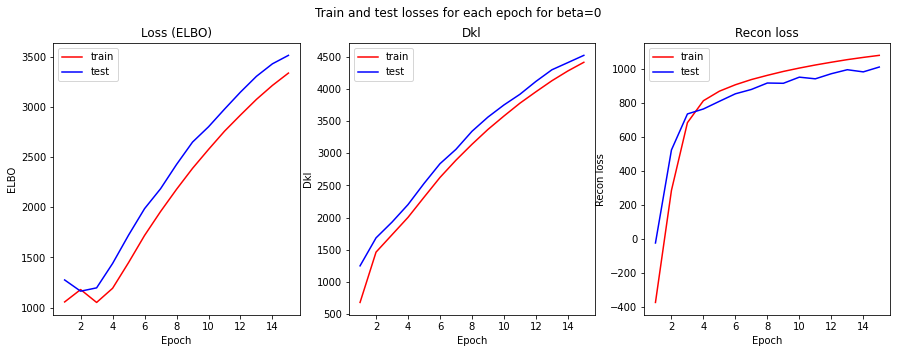

Done!


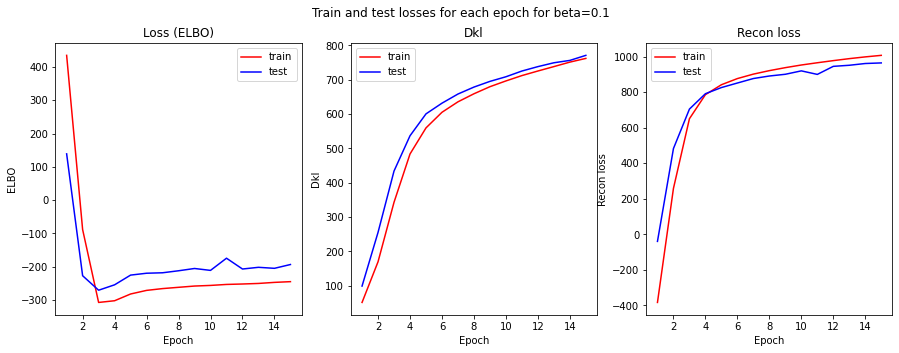

Done!


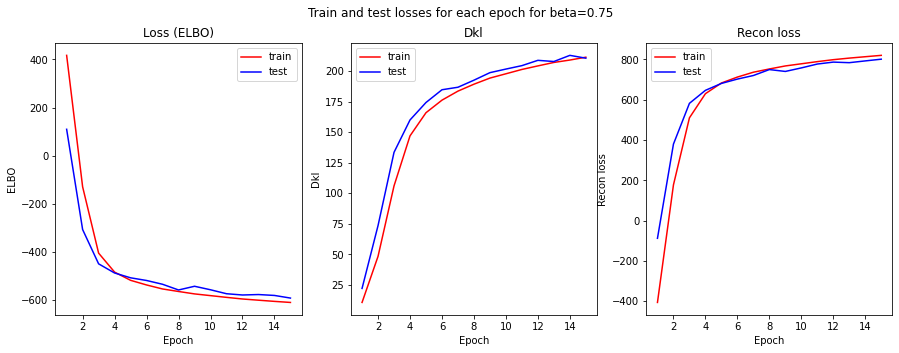

Done!


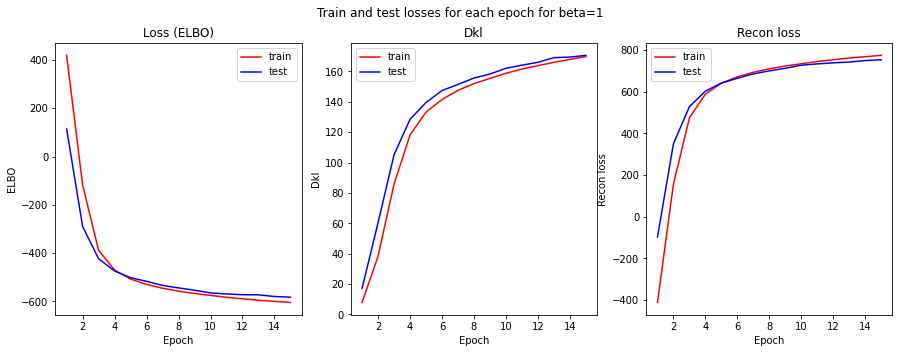

Done!


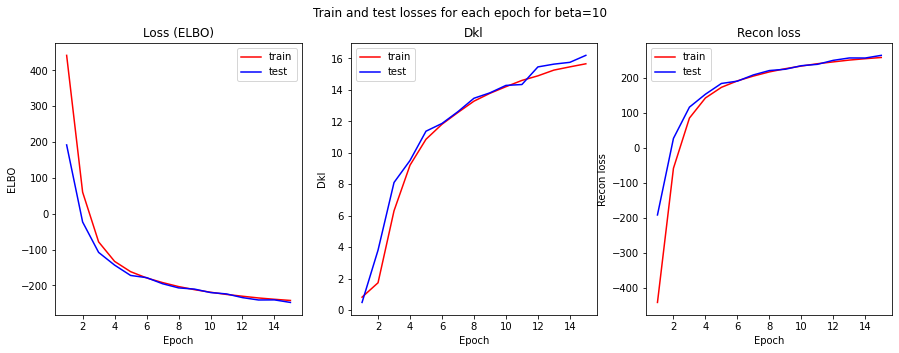

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

for b in [0, 0.1, 0.75, 1, 10]:
  encoder_nn = EncoderNN(28*28, 128)
  decoder_nn = DecoderNN(28*28, 128)
  vae = VariationalAutoencoder(encoder_nn, decoder_nn, beta=b)
  optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
  epochs = 15

  train_elbo_list = []
  train_Dkl_list = []
  train_recon_loss_list = []
  test_elbo_list = []
  test_Dkl_list = []
  test_recon_loss_list = []


  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      elbo_train, Dkl_train, recon_loss_train = train(vae, train_dataloader, optimizer, device)
      train_elbo_list.append(elbo_train)
      train_Dkl_list.append(Dkl_train)
      train_recon_loss_list.append(recon_loss_train)
      
      elbo_test, Dkl_test, recon_loss_test = test(vae, test_dataloader, device)
      test_elbo_list.append(elbo_test)
      test_Dkl_list.append(Dkl_test)
      test_recon_loss_list.append(recon_loss_test)

  print("Done!")

  fig, axes = plt.subplots(1, 3, figsize=(15,5))

  epochs_list = [t+1 for t in range(epochs)]
  train_elbo_list_np = [float(obs.cpu().detach().numpy()) for obs in train_elbo_list]
  test_elbo_list_np = [float(obs.cpu().detach().numpy()) for obs in test_elbo_list]
  train_Dkl_list_np = [float(obs.cpu().detach().numpy()) for obs in train_Dkl_list]
  test_Dkl_list_np = [float(obs.cpu().detach().numpy()) for obs in test_Dkl_list]
  train_recon_loss_list_np = [float(obs.cpu().detach().numpy()) for obs in train_recon_loss_list]
  test_recon_loss_list_np = [float(obs.cpu().detach().numpy()) for obs in test_recon_loss_list]


  fig.suptitle(f'Train and test losses for each epoch for beta={b}')
  axes[0].plot(epochs_list, train_elbo_list_np, label='train', color='r')
  axes[0].plot(epochs_list, test_elbo_list_np, label='test', color='b')
  axes[0].set_title('Loss (ELBO)')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('ELBO')
  axes[0].legend()

  axes[1].plot(epochs_list, train_Dkl_list_np, label='train', color='r')
  axes[1].plot(epochs_list, test_Dkl_list_np, label='test', color='b')
  axes[1].set_title('Dkl')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Dkl')
  axes[1].legend()

  axes[2].plot(epochs_list, train_recon_loss_list_np, label='train', color='r')
  axes[2].plot(epochs_list, test_recon_loss_list_np, label='test', color='b')
  axes[2].set_title('Recon loss')
  axes[2].set_xlabel('Epoch')
  axes[2].set_ylabel('Recon loss')
  axes[2].legend()

  plt.show()

In [18]:
vae.eval()
from tqdm import tqdm

with torch.no_grad():
 for batch_idx, (x, _) in enumerate(tqdm(test_dataloader)):
    x = x.view(64, 784)
    pred, _, _, _, _, x_hat, _ = vae(x)
    break

def show_image(x, idx):
 x = x.view(64, 28, 28)

 fig = plt.figure()
 plt.imshow(x[idx].cpu().numpy())

  0%|          | 0/157 [00:00<?, ?it/s]


RuntimeError: ignored

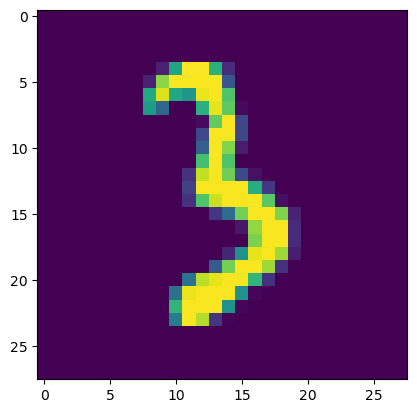

In [ ]:
show_image(x, idx=44)

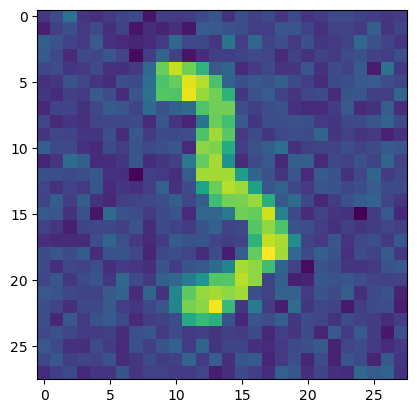

In [ ]:
show_image(x_hat, idx=44)